In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import datetime

In [65]:
def read_and_preprocess(path):
    archive = zipfile.ZipFile(path, 'r')
    file = archive.open("MetroPT3(AirCompressor).csv")
    df = pd.read_csv(file)
    df.drop("Unnamed: 0",axis=1,inplace=True)
    df["Failure"] = 0
    df.timestamp = pd.to_datetime(df.timestamp)
    df["Hour"] = df.timestamp.dt.hour
    df["Minute"] = df.timestamp.dt.minute
    df["Second"] = df.timestamp.dt.second
    df = df.set_index("timestamp")
    df.loc["2020-04-18 00:00:00":"2020-04-18 23:59:00","Failure"] = 1
    df.loc["2020-05-29 23:30:00":"2020-05-30 06:00:00","Failure"] = 1
    df.loc["2020-06-05 10:00:00":"2020-06-07 14:30:00","Failure"] = 1
    df.loc["2020-07-15 14:30:00":"2020-07-15 19:00:00","Failure"] = 1
    
    print("Reading and preprocess is successful!")
    return df

In [126]:
data = read_and_preprocess("data.zip")

Reading and preprocess is successful!


In [127]:
lagged_features = ["TP3","DV_pressure","H1","Motor_current","Oil_temperature","Reservoirs","TP2"]
for feat in lagged_features:
    data[f'lagged_{feat}'] = data[feat].shift(1)
    data.loc[data.index.min(),f'lagged_{feat}'] = data.loc[data.index.min(),feat]

In [129]:
TARGET = "Failure"
FEATURES = data.drop(TARGET,axis=1).columns

<Axes: >

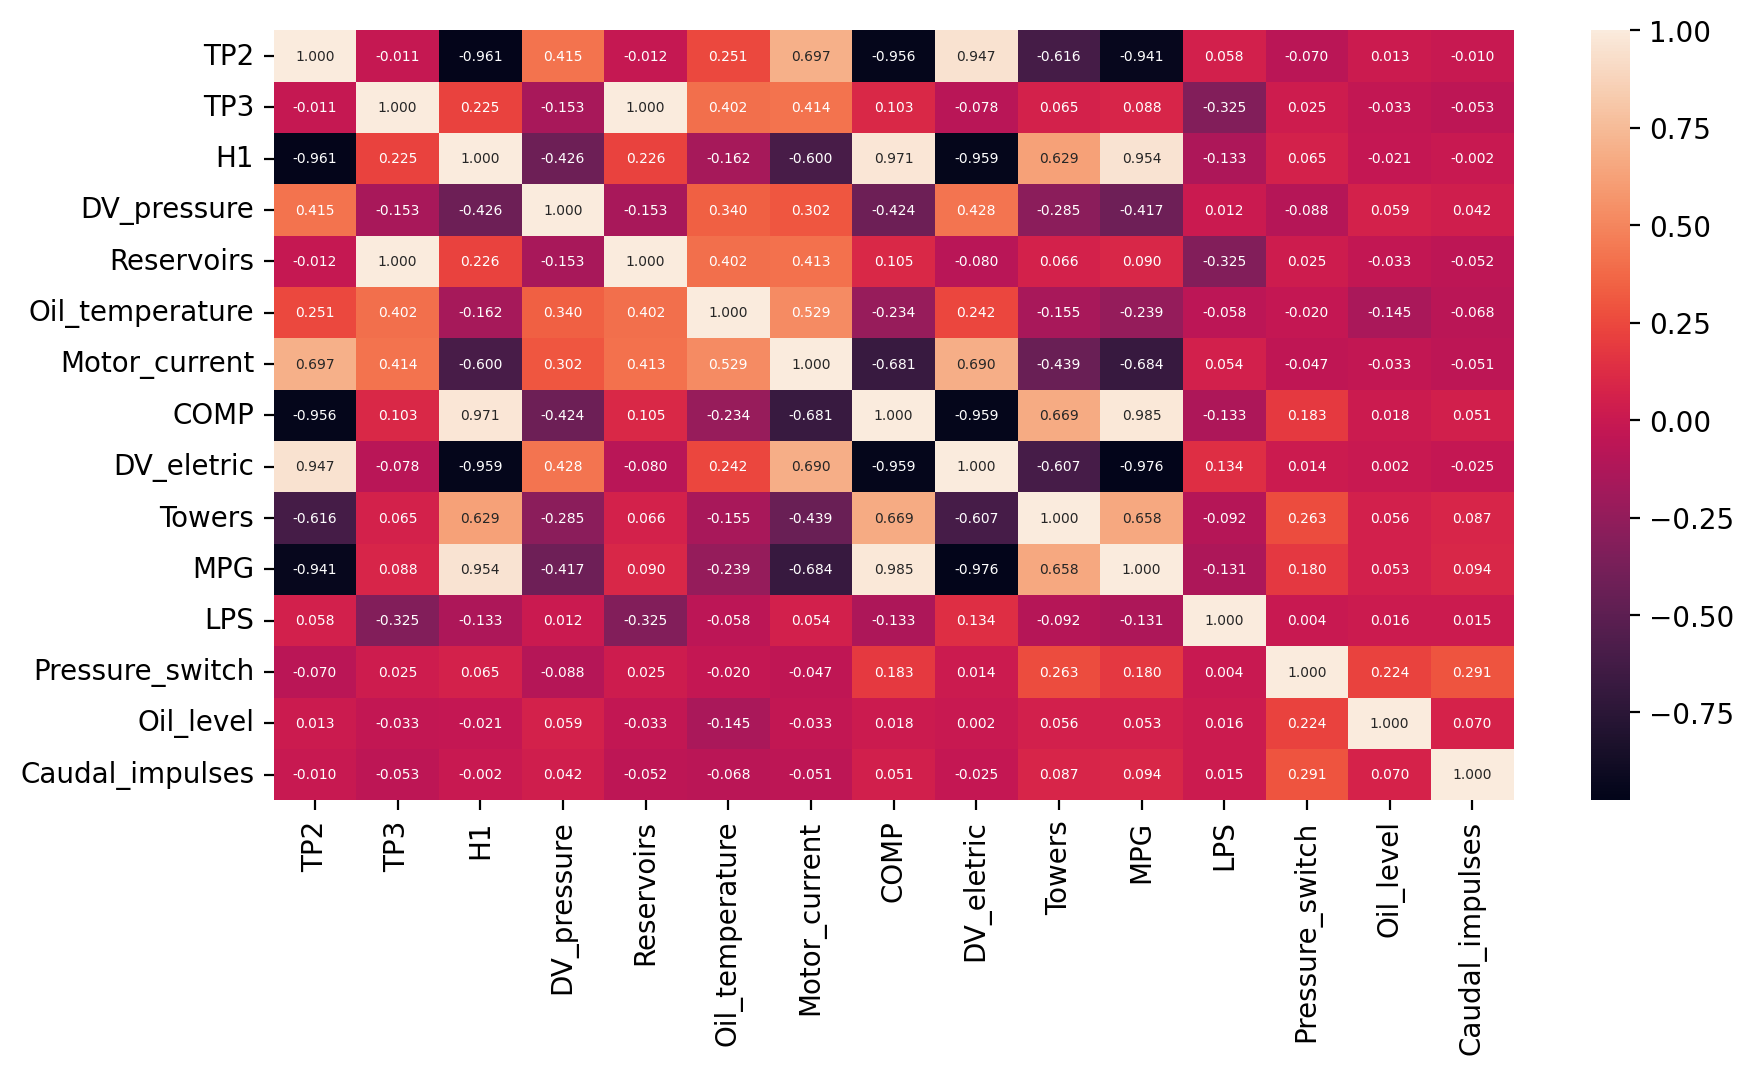

In [149]:
corr_df = data[data.columns[:15]].corr()
plt.figure(figsize=(10,5),dpi=200)
sns.heatmap(corr_df,annot=True,fmt=".3f",annot_kws={"size":5})

In [28]:
print("Data Summary when there is a failure")
failure_df = data[data.Failure == 1]
failure_df.describe().T

Data Summary when there is a failure


,count,mean,std,min,25%,50%,75%,max
TP2,29954.0,8.115287,0.982387,-0.020,7.9600,8.2720,8.604,10.6040
TP3,29954.0,8.288059,0.495399,2.816,7.9720,8.1700,8.748,10.2280
H1,29954.0,0.037668,0.627408,-0.014,-0.0080,-0.0080,-0.006,10.2280
DV_pressure,29954.0,1.859813,0.519533,-0.024,1.8720,2.0120,2.130,2.3320
Reservoirs,29954.0,8.289548,0.495344,2.806,7.9740,8.1720,8.750,10.2320
Oil_temperature,29954.0,75.598441,2.931952,39.625,74.7250,75.4750,76.175,89.0500
Motor_current,29954.0,5.532224,0.366727,0.025,5.4725,5.5725,5.670,6.1475
COMP,29954.0,0.004440,0.066487,0.000,0.0000,0.0000,0.000,1.0000
DV_eletric,29954.0,0.994892,0.071288,0.000,1.0000,1.0000,1.000,1.0000
Towers,29954.0,0.501970,0.500004,0.000,0.0000,1.0000,1.000,1.0000


In [29]:
print("Data Summary when there isn't a failure")
non_failure_df = data[data.Failure == 0]
non_failure_df.describe().T

Data Summary when there isn't a failure


,count,mean,std,min,25%,50%,75%,max
TP2,1486994.0,1.231905,3.134709,-0.032,-0.014,-0.012,-0.010,10.676
TP3,1486994.0,8.998642,0.633842,0.730,8.506,8.978,9.502,10.302
H1,1486994.0,7.719849,3.187593,-0.036,8.278,8.808,9.386,10.288
DV_pressure,1486994.0,0.019619,0.277259,-0.032,-0.022,-0.020,-0.018,9.844
Reservoirs,1486994.0,8.999247,0.633052,0.712,8.506,8.980,9.502,10.300
Oil_temperature,1486994.0,62.383231,6.300423,15.400,57.675,62.550,66.975,83.125
Motor_current,1486994.0,1.980028,2.270316,0.020,0.040,0.045,3.795,9.295
COMP,1486994.0,0.853727,0.353380,0.000,1.000,1.000,1.000,1.000
DV_eletric,1486994.0,0.143805,0.350892,0.000,0.000,0.000,0.000,1.000
Towers,1486994.0,0.928266,0.258047,0.000,1.000,1.000,1.000,1.000


In [132]:
binary_cols = []
non_binary_cols = []
for col in data.columns:
    if data[col].nunique() ==2:
        binary_cols.append(col)
        print(f"{col} unique values: {data[col].nunique()}")
    else:
        print(f"{col} unique values: {data[col].nunique()}")
        non_binary_cols.append(col)
    

TP2 unique values: 5257
TP3 unique values: 3683
H1 unique values: 2665
DV_pressure unique values: 2257
Reservoirs unique values: 3682
Oil_temperature unique values: 2462
Motor_current unique values: 1809
COMP unique values: 2
DV_eletric unique values: 2
Towers unique values: 2
MPG unique values: 2
LPS unique values: 2
Pressure_switch unique values: 2
Oil_level unique values: 2
Caudal_impulses unique values: 2
Failure unique values: 2
Hour unique values: 24
Minute unique values: 60
Second unique values: 60
lagged_TP3 unique values: 3683
lagged_DV_pressure unique values: 2257
lagged_H1 unique values: 2665
lagged_Motor_current unique values: 1809
lagged_Oil_temperature unique values: 2462
lagged_Reservoirs unique values: 3682
lagged_TP2 unique values: 5257


In [8]:
def visualize_timeseries(df,start_time,day_count:int,hour_count,col,save=False):
    '''
    day_count: number of days to add to the start time
    hour_count: number of hours to add to the start_time
    save: if True, saves the figure
    
    '''
    start_time = pd.to_datetime(start_time)
    end_time = start_time + datetime.timedelta(days=day_count,hours=hour_count)
    

    
    
    df_slice = df.loc[start_time:end_time]


    failure_data_idx = df_slice[df_slice["Failure"]==1].index
    non_failure_data_idx = df_slice[df_slice["Failure"]==0].index

    plt_name = f"{col} plot from {start_time} - {end_time}"
    plt.figure(figsize=(15,5))
    plt.title(plt_name)

    for idx in df_slice.index:
        if idx in failure_data_idx:
            plt.plot(idx,df_slice.loc[idx][col],"r.")
        elif idx in non_failure_data_idx:
            plt.plot(idx,df_slice.loc[idx][col],"b.")

    # plt.plot(failure_data_idx,df_slice.loc[failure_data_idx][col],"r-")
    # plt.plot(non_failure_data_idx,df_slice.loc[non_failure_data_idx][col],"b-")

    
    
    # sns.scatterplot(data=df_slice,x=df_slice.index,y=col,hue="Failure")
    if save:
        plt.savefig("plots/" + plt_name + ".png")
    
    plt.show()
    return None
    
    

In [130]:
#Manually Splitting the data since this is a time series data
test_start_date = "2020-07-02 00:00:00"
train_end_date = "2020-07-01 23:59:55"

X_train , y_train, X_test, y_test = data[FEATURES].loc[:train_end_date],data[TARGET].loc[:train_end_date], data[FEATURES].loc[test_start_date:], data[TARGET].loc[test_start_date:]


### Feature Engineering

In [52]:
from sklearn.model_selection import TimeSeriesSplit
tss_idx = TimeSeriesSplit(n_splits=4)

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [133]:
for i in ["Hour","Minute","Second"]:
    non_binary_cols.remove(i)

In [134]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [135]:
ct = ColumnTransformer(
    [
        ("num",StandardScaler(),non_binary_cols)
    ]
)


pipe = Pipeline([
    ("ColTrans",ct),
    ("Model",RandomForestClassifier())
])

In [136]:
pipe.fit(X_train,y_train)


KeyboardInterrupt: 

In [ ]:
x_test_score =pipe.score(X_test,y_test)
all_zeros_score = pipe.score(X_test,np.zeros(len(y_test)))

In [112]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pipe.predict(X_test))

<Axes: >

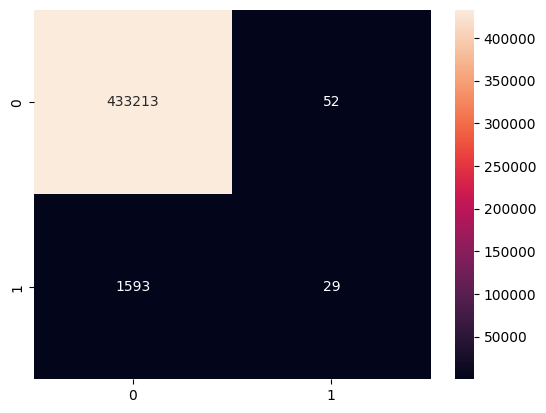

In [113]:
sns.heatmap(cm,annot=True,fmt=".0f")